In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


# Data

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e6/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e6/test.csv")

sample = pd.read_csv("/kaggle/input/playground-series-s4e6/sample_submission.csv")

In [3]:
ord_cols = ["Application order", "Previous qualification", "Mother's qualification", "Father's qualification"]

cat_cols = ["Marital status", "Application mode", "Nacionality", "Course", "Mother's occupation", "Father's occupation", 
            "Daytime/evening attendance", "Displaced", "Educational special needs", "Debtor", "Tuition fees up to date", 
            "Gender", "Scholarship holder", "International"]

num_cols = ["Previous qualification (grade)", "Admission grade", "Age at enrollment", 
            "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)", "Curricular units 1st sem (evaluations)", 
            "Curricular units 1st sem (approved)", "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)", 
            "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)", "Curricular units 2nd sem (evaluations)", 
            "Curricular units 2nd sem (approved)", "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (without evaluations)", 
            "Unemployment rate", "Inflation rate", "GDP"]

target = ["Target"]

# Imports

In [17]:
from scipy import stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# Pipeline

In [5]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [6]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ord_cols),
    ('ohe_p', ohe_pipeline, cat_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [7]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [8]:
X = train_df.drop(columns=['id', 'Target'], axis=1)
y = train_df['Target']

In [9]:
X_preprocessed = pipeline.fit_transform(X)

# Kmeans

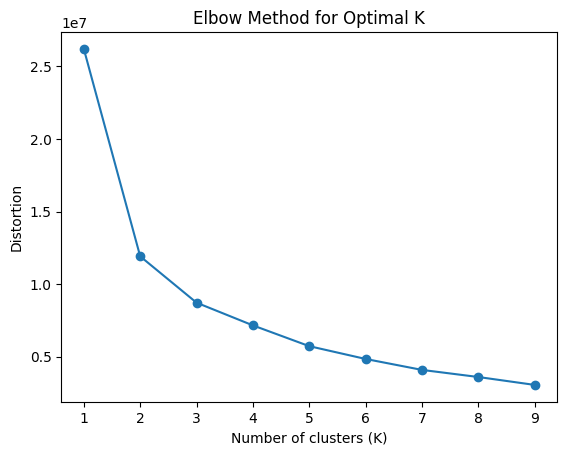

In [10]:
from sklearn.cluster import KMeans

distortions = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(X_preprocessed)
    distortions.append(kmeans.inertia_) 
    
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto")
kmeans.fit(X_preprocessed)
x_cluster_labels = kmeans.labels_
print(x_cluster_labels)

[0 7 0 ... 8 8 7]


In [12]:
X_with_clusters = np.c_[X, x_cluster_labels]

label_mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
encoded_y = y.map(label_mapping)

# Model Building

**SGD Classifier**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, encoded_y, test_size=0.15, random_state=25)

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
clf.fit(X_train, y_train)

sgd_pred = clf.predict(X_test)

reverse_label_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}

decoded_pred_sgd = [reverse_label_mapping[label] for label in sgd_pred]

decoded_test = [reverse_label_mapping[label] for label in y_test]

accuracy_sgd = accuracy_score(decoded_test, decoded_pred_sgd)

print("Accuracy:", accuracy_sgd)

Accuracy: 0.7801010629029448


Kmeans acc is 0.72417

Normal Pipeline acc is 0.78010

**Keeping normal pipeline and not doing kmeans** due to lower accuracy with Kmeans

**Random Forest Classifier**

In [27]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

print(rfc_pred)

decoded_pred_rfc = [reverse_label_mapping[label] for label in rfc_pred]

accuracy_rfc = accuracy_score(decoded_test, decoded_pred_rfc)

print("Accuracy:", accuracy_rfc)

[0 1 0 ... 2 0 2]
Accuracy: 0.8288029273392578


Random Forest Acc is about 0.8288

**Cat Boost Classifier**

In [39]:
cbc = CatBoostClassifier(verbose=0)

cbc.fit(X_train, y_train)

cbc_pred = cbc.predict(X_test)

flattened = []

for arr in cbc_pred:
    flattened.extend(arr)

#print(flattened)

decoded_pred_cbc = [reverse_label_mapping[label] for label in flattened]

accuracy_cbc = accuracy_score(decoded_test, decoded_pred_cbc)

print("Accuracy:", accuracy_cbc)

Accuracy: 0.835250043561596


Cat Boost Classifier acc is about 0.8352

**XGB Classifier**

In [41]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

print(xgb_pred)

decoded_pred_xgb = [reverse_label_mapping[label] for label in xgb_pred]

accuracy_xgb = accuracy_score(decoded_test, decoded_pred_xgb)

print("Accuracy:", accuracy_xgb)

[0 1 0 ... 2 0 2]
Accuracy: 0.8339431956786897


XGB acc is about 0.8339

**Deep Learning**

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import layers


**HistGradientBoosting Classifier**

In [47]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier()

hgb.fit(X_train, y_train)

hgb_pred = hgb.predict(X_test)

print(hgb_pred)

decoded_pred_hgb = [reverse_label_mapping[label] for label in hgb_pred]

accuracy_hgb = accuracy_score(decoded_test, decoded_pred_hgb)

print("Accuracy:", accuracy_hgb)

[0 1 0 ... 2 0 2]
Accuracy: 0.8330719637567521


hgb acc is about 0.83307

**ADA Boost**

In [50]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()

ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

print(ada_pred)

decoded_pred_ada = [reverse_label_mapping[label] for label in ada_pred]

accuracy_ada = accuracy_score(decoded_test, decoded_pred_ada)

print("Accuracy:", accuracy_ada)

[0 1 0 ... 2 0 2]
Accuracy: 0.8246210141139572


ada acc is 0.8246

**Voting Classifier**

In [51]:
vc = VotingClassifier([('rfc', rfc),
                      ('xgb', xgb),
                       ('ada', ada),
                      ('hgb', hgb)], 
                      weights=[2, 4, 1, 3])

vc.fit(X_train, y_train)
vc_pred = vc.predict(X_test)

print(vc_pred)

decoded_pred_vc = [reverse_label_mapping[label] for label in vc_pred]

accuracy_vc = accuracy_score(decoded_test, decoded_pred_vc)

print("Accuracy:", accuracy_vc)

[0 1 0 ... 2 0 2]
Accuracy: 0.834901550792821


**Stacking**

In [52]:
estimators = [
    ('cbc', cbc),
    ('xgb', xgb),
    ('hgb', hgb),
    ('rfc', rfc)
]

In [53]:
stack = StackingClassifier(estimators=estimators, final_estimator=vc)

stack.fit(X_train, y_train)

stack_pred = stack.predict(X_test)

print(stack_pred)

[0 1 0 ... 2 0 2]


In [54]:
decoded_pred_stack = [reverse_label_mapping[label] for label in stack_pred]

accuracy_stack = accuracy_score(decoded_test, decoded_pred_stack)

print("Accuracy:", accuracy_stack)

Accuracy: 0.8365568914445025


# Submission

In [56]:
test_df_preprocessed = test_df.drop("id", axis=1)

test_df_preprocessed = pipeline.transform(test_df_preprocessed)

In [57]:
sub_pred = stack.predict(test_df_preprocessed)

decoded_sub = [reverse_label_mapping[label] for label in sub_pred]

submission = pd.DataFrame({'id': test_df['id'], 'Target': decoded_sub})

print(submission.head())
print(f"Submission data shape: {submission.shape}")

submission.to_csv('submission.csv', index=False)

      id    Target
0  76518   Dropout
1  76519  Graduate
2  76520  Graduate
3  76521  Enrolled
4  76522  Enrolled
Submission data shape: (51012, 2)
